Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

Без подписки:\
абонентская плата отсутствует;\
стоимость одной минуты поездки — 8 рублей;\
стоимость старта (начала поездки) — 50 рублей;

С подпиской Ultra:\
абонентская плата — 199 рублей в месяц;\
стоимость одной минуты поездки — 6 рублей;\
стоимость старта — бесплатно.

**Описание данных**\
В основных данных есть информация о пользователях, их поездках и подписках.

Пользователи — `users_go.csv`\
`user_id` — уникальный идентификатор пользователя\
`name` — имя пользователя\
`age` — возраст\
`city` — город\
`subscription_type` — тип подписки (free, ultra)

Поездки — `rides_go.csv`\
`user_id` — уникальный идентификатор пользователя\
`distance` — расстояние, которое пользователь проехал в текущей сессии (в метрах)\
`duration` — продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»\
`date` — дата совершения поездки

Подписки — `subscriptions_go.csv`\
`subscription_type` — тип подписки\
`minute_price` — стоимость одной минуты поездки по данной подписке\
`start_ride_price` — стоимость начала поездки\
`subscription_fee` — стоимость ежемесячного платежа

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import stats
from scipy.stats import binom
from scipy.stats import norm
from scipy.stats import poisson

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.0f}'.format)

#### Шаг 1. Загрузка данных

#####  Считываение данных

Запишем данные из датасетов в соответсвующие датафреймы. Используем параметр `parse_dates` для столбца `dates` в датафрейме `data_rides` - так мы сразу приведем данные к типу даты.

In [2]:
data_users = pd.read_csv('/datasets/users_go.csv')

data_rides = pd.read_csv('/datasets/rides_go.csv', parse_dates=['date'])

data_subs = pd.read_csv('/datasets/subscriptions_go.csv')

##### Первое впечатление

Выведем по 5 первых строк каждого датафрема при помощи метода `head()`, а также общую информацию, используя `info()`.

In [3]:
data_users.head(5)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


В датафрейме с пользователями явных пропусков нет, все строки заполнены, а типы данных соотвествуют заданным.

In [5]:
data_rides.head(5)

,user_id,distance,duration,date
0,1,4410,26,2021-01-01
1,1,2618,16,2021-01-18
2,1,754,6,2021-04-20
3,1,2695,19,2021-08-11
4,1,4029,26,2021-08-28


In [6]:
data_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


Явные пропуски снова отсутсвуют.

In [7]:
data_subs.head(5)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [8]:
data_subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


##### Промежуточный вывод 

Датафреймы не имеют ни одного пропуска, что может говорить о том, что при передаче данных не произошло каких-то неполадок. Про дубликаты говорить пока рано - они будут изучены в процессе предобработки данных.

#### Шаг 2. Предобработка данных

##### Номер месяца

In [9]:
data_rides['month'] = data_rides['date'].dt.month

data_rides.head(5)

,user_id,distance,duration,date,month
0,1,4410,26,2021-01-01,1
1,1,2618,16,2021-01-18,1
2,1,754,6,2021-04-20,4
3,1,2695,19,2021-08-11,8
4,1,4029,26,2021-08-28,8


##### Наличие пропусков и дубликатов

###### Датафрейм data_users

Посчитаем количество полных дубликатов: 

In [10]:
data_users['user_id'].duplicated().sum()

31

In [11]:
data_users[data_users['user_id'].duplicated()]

,user_id,name,age,city,subscription_type
1534,293,Агата,26,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
1536,909,Константин,20,Екатеринбург,free
1537,403,Полина,19,Сочи,ultra
1538,908,Рустам,30,Тюмень,free
1539,43,Стефания,22,Омск,ultra
1540,127,Павел,25,Пятигорск,ultra
1541,659,Злата,27,Ростов-на-Дону,ultra
1542,204,Руслан,30,Пятигорск,ultra
1543,153,Герман,23,Москва,ultra


По неизвестным причинам последние 30 строк датафрейма `data_users` оказались полными дубликатами - такое нас не устраивает. Удалим эти строки.

In [12]:
data_users = data_users.drop_duplicates()
data_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB


In [13]:
len(data_users['user_id'].unique())

1534

Проводить более глубокую проверку не имеет смысла - все id теперь уникальны, а повторы в остальных 4-х столбцах не являются искажением и т.д. - так как это названия, имена, возраст и тип подписки.

###### Датафрейм data_rides

In [14]:
data_rides.duplicated().unique()

array([False])

Явные дубликаты отсутствуют. Это означает, что все поездки уникальны. Столбцы могут повторяться, т.к. это датафрейм, который является просто набором записей о поездках.

##### Промежуточный вывод

Дубликаты присутствовали только в одном датафрейме - `data_users`. Почему-то в самом конце датафрейма оказались дубликаты некоторых строк. С чем это связано - неизвестно, но скорее всего, данные продублировались при выгрузке из сервиса.

Все столбцы, кроме `user_id` в этом датафрейме могут дублироваться - имена, города и т.д.

В датафрейме `data_rides` явные дубликаты отсутсвуют, что тоже говорит о том, что данные собраны корректно. В данном случае дубликаты могут быть в любом столбце, так как это, грубо говоря, логи поездок.

#### Шаг 3. Исследовательский анализ данных

##### Частота встречаемости городов

Построим график распределение по городам, предварительно сгруппировав данные при помощи сводной таблицы:

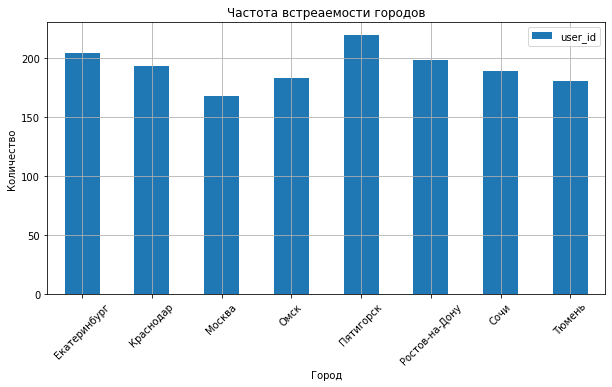

,user_id
city,
Екатеринбург,204
Краснодар,193
Москва,168
Омск,183
Пятигорск,219
Ростов-на-Дону,198
Сочи,189
Тюмень,180


In [15]:
data_users_city = data_users.pivot_table(index='city', values='user_id', aggfunc='count')

data_users_city_plot = data_users_city.plot(kind='bar', grid=True, figsize=(10, 5))
data_users_city_plot.set_title('Частота встреаемости городов')
data_users_city_plot.set_xlabel('Город')
data_users_city_plot.set_ylabel('Количество')

data_users_city_plot.set_xticks(range(len(data_users_city.index)))
data_users_city_plot.set_xticklabels(data_users_city.index, rotation=45)

plt.show()
data_users_city

##### Соотношение пользователей с подпиской и без подписки

Сделаем то же самое, что и в предыдущем пункте:

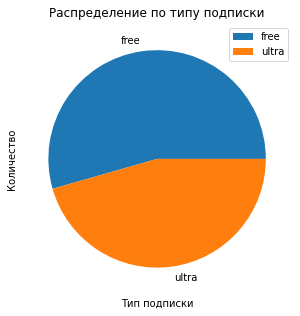

In [16]:
data_users_subs_plot = (data_users.pivot_table(index='subscription_type', values='user_id', aggfunc='count')
                   .plot(y='user_id', kind='pie', figsize=(10, 5)))

data_users_subs_plot.set_title('Распределение по типу подписки')
data_users_subs_plot.set_xlabel('Тип подписки')
data_users_subs_plot.set_ylabel('Количество')

plt.show()

Взглянем на количество пользователей с подпиской и без нее:

In [17]:
data_users.pivot_table(index='subscription_type', values='user_id', aggfunc='count')

,user_id
subscription_type,
free,835
ultra,699


##### Возраст пользователей

Также при помощи сводной таблицы построим распределение пользователей по возрасту:

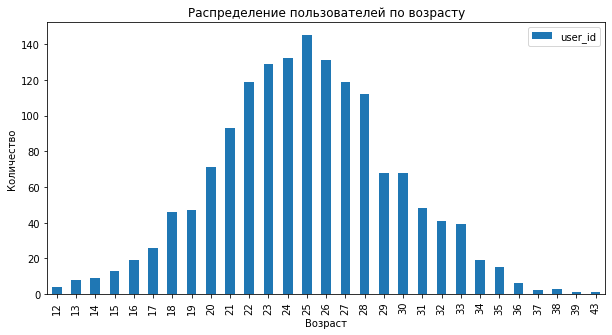

In [18]:
data_users_age_plot = data_users.pivot_table(index='age', values='user_id', aggfunc='count').plot(kind='bar', figsize=(10, 5))

data_users_age_plot.set_title('Распределение пользователей по возрасту')
data_users_age_plot.set_xlabel('Возраст')
data_users_age_plot.set_ylabel('Количество')

plt.show()

In [19]:
data_users['age'].describe()

count   1534
mean      25
std        5
min       12
25%       22
50%       25
75%       28
max       43
Name: age, dtype: float64

Посмотрим на средний и медианный возраст:

In [20]:
print(f'Средний возраст пользователей: {data_users["age"].mean()}')
print(f'Медианный возраст пользователей: {data_users["age"].median()}')

Средний возраст пользователей: 24.903520208604956
Медианный возраст пользователей: 25.0


Средний и медианный возраст практически совпадают. О чем это говорит? Собранные данные хорошего качества, не имеют серьезных выбросов и каких-то иных аномалий.

##### Расстояние, которое пользователь преодолел за одну поездку

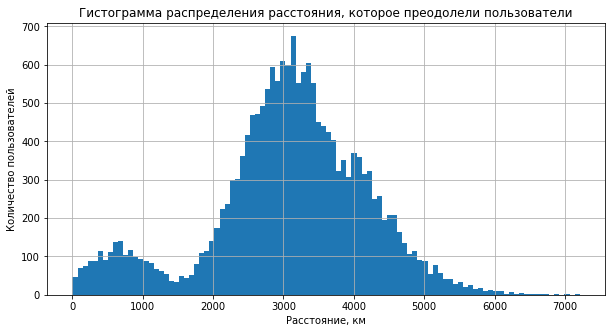

In [21]:
data_rides_distance_plot = data_rides['distance'].plot(kind='hist', bins=100, grid=True, figsize=(10, 5));

data_rides_distance_plot.set_title('Гистограмма распределения расстояния, которое преодолели пользователи')
data_rides_distance_plot.set_xlabel('Расстояние, км')
data_rides_distance_plot.set_ylabel('Количество пользователей')

plt.show()

Распределение достаточно хаотичное. Имеет два пика - до 1.5 тысяч и между 1.5 и 7к.

In [22]:
data_rides['distance'].describe()

count   18068
mean     3071
std      1117
min         1
25%      2543
50%      3134
75%      3776
max      7211
Name: distance, dtype: float64

##### Продолжительность поездок.

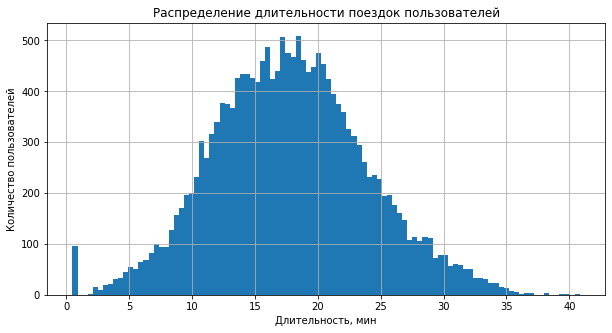

In [23]:
data_rides_duration_plot = data_rides['duration'].plot(kind='hist', bins=100, grid=True, figsize=(10, 5));

data_rides_duration_plot.set_title('Распределение длительности поездок пользователей')
data_rides_duration_plot.set_xlabel('Длительность, мин')
data_rides_duration_plot.set_ylabel('Количество пользователей')

plt.show()

Распределение продолжительности поездок напоминает нормальное. Также наблюдается выброс около нуля - скорее всего, пользователь начал и резко закончил поездку, даже не встав на самокат. Либо же произошла какая-то поломка при передаче данных, и часть значений (почти 100) стала равна определенной величине.

In [24]:
data_rides['duration'].describe()

count   18068
mean       18
std         6
min         0
25%        14
50%        18
75%        22
max        41
Name: duration, dtype: float64

**Общий вывод**

На основании проведенного исследовательского анализа данных можно сделать следующие выводы:

**Частота встречаемости городов**
Анализ частоты встречаемости пользователей по городам показал, что наибольшее количество пользователей проживает в Пятигорске (219 пользователей), за ним следуют Екатеринбург (204 пользователя) и Ростов-на-Дону (198 пользователей). Наименьшее количество пользователей зарегистрировано в Москве (168 пользователей). Это может свидетельствовать о том, что сервис наиболее популярен в регионах, а не в столице.

**Соотношение пользователей с подпиской и без подписки**
Распределение пользователей по типу подписки показало, что большее количество пользователей используют бесплатную подписку (835 пользователей), в то время как платную подписку "ultra" используют 699 пользователей. Это может указывать на то, что пользователи предпочитают сначала попробовать сервис бесплатно, прежде чем переходить на платную подписку.

**Возраст пользователей**
Распределение пользователей по возрасту показало, что средний возраст пользователей составляет примерно 24.9 года, а медианный возраст — 25 лет. Практически совпадение среднего и медианного возраста говорит о том, что данные не содержат серьезных выбросов и аномалий, что свидетельствует о хорошем качестве данных.

**Расстояние, которое пользователь преодолел за одну поездку**
Анализ расстояний, которые пользователи преодолевают за одну поездку, показал, что распределение имеет два пика: до 1.5 тысяч и между 1.5 и 7 тысяч. Среднее расстояние составляет 3071 метр, что говорит о том, что пользователи в среднем преодолевают значительные расстояния. Однако, наблюдаются значительные колебания, что может быть связано с различными целями поездок.

**Продолжительность поездок**
Распределение продолжительности поездок напоминает нормальное распределение с выбросом около нуля. Средняя продолжительность поездки составляет 18 минут. Выбросы около нуля могут быть связаны с техническими проблемами или ошибками при передаче данных, когда поездка была начата и сразу же завершена.

**Заключение**
Проведенный анализ данных показал, что сервис пользуется популярностью в различных городах, особенно в регионах. Большинство пользователей предпочитают бесплатную подписку, что может свидетельствовать о необходимости улучшения маркетинговых стратегий для привлечения пользователей к платным подпискам. Возрастная группа пользователей достаточно однородна, что говорит о хорошем качестве данных. Анализ расстояний и продолжительности поездок показал, что пользователи активно используют сервис для преодоления значительных расстояний и времени, несмотря на некоторые технические проблемы.

#### Шаг 4. Объединение данных

In [25]:
data = data_users.merge(data_rides, 'left').merge(data_subs, 'left')
data

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4410,26,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2618,16,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754,6,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2695,19,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4029,26,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781,20,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840,21,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826,18,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902,17,2021-11-27,11,8,50,0


In [26]:
data_with_sub = data.query('subscription_type == "ultra"')
data_with_sub

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4410,26,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2618,16,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754,6,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2695,19,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4029,26,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973,25,2021-08-29,8,6,0,199
6496,699,Оксана,22,Москва,ultra,3289,16,2021-09-12,9,6,0,199
6497,699,Оксана,22,Москва,ultra,3076,14,2021-09-26,9,6,0,199
6498,699,Оксана,22,Москва,ultra,4708,16,2021-10-17,10,6,0,199


In [27]:
data_no_sub = data.query('subscription_type == "free"').reset_index(drop=True)
data_no_sub

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,700,Айдар,22,Омск,free,2516,15,2021-01-02,1,8,50,0
1,700,Айдар,22,Омск,free,847,16,2021-02-01,2,8,50,0
2,700,Айдар,22,Омск,free,4004,20,2021-02-04,2,8,50,0
3,700,Айдар,22,Омск,free,1206,10,2021-02-10,2,8,50,0
4,700,Айдар,22,Омск,free,3047,17,2021-02-14,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11563,1534,Альберт,25,Краснодар,free,3781,20,2021-11-04,11,8,50,0
11564,1534,Альберт,25,Краснодар,free,2840,21,2021-11-16,11,8,50,0
11565,1534,Альберт,25,Краснодар,free,3826,18,2021-11-18,11,8,50,0
11566,1534,Альберт,25,Краснодар,free,2902,17,2021-11-27,11,8,50,0


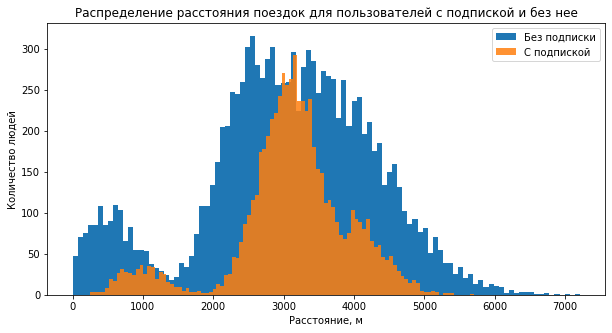

In [28]:
data_no_sub_plot = data_no_sub['distance'].plot(kind='hist', bins=100, figsize=(10, 5), label='Без подписки')
data_with_sub_plot = data_with_sub['distance'].plot(kind='hist', bins=100, figsize=(10, 5), alpha=0.85, label='С подпиской')


data_with_sub_plot.set_title('Распределение расстояния поездок для пользователей с подпиской и без нее')
data_with_sub_plot.set_xlabel('Расстояние, м')
data_with_sub_plot.set_ylabel('Количество людей')

plt.legend()

plt.show()

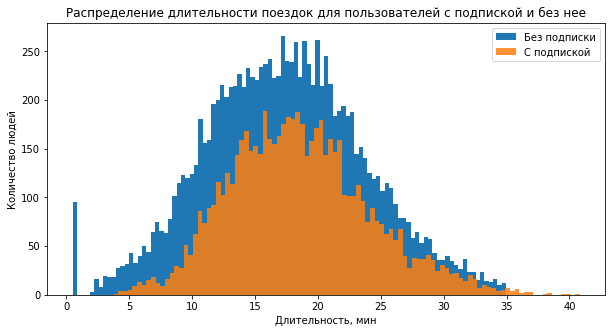

In [29]:
data_no_sub_plot = data_no_sub['duration'].plot(kind='hist', bins=100, figsize=(10, 5), label='Без подписки')
data_with_sub_plot = data_with_sub['duration'].plot(kind='hist', bins=100, figsize=(10, 5), alpha=0.85, label='С подпиской')


data_with_sub_plot.set_title('Распределение длительности поездок для пользователей с подпиской и без нее')
data_with_sub_plot.set_xlabel('Длительность, мин')
data_with_sub_plot.set_ylabel('Количество людей')

plt.legend()

plt.show()

**Промежуточный вывод**

На графиках отчетливо видно, что пользователей без подписки немного больше, чем пользователей, купивших её. В целом, это подтверждает ранее исследованные значения распределения. Помимо того, что пользователей без подписки больше, они также чаще используют данный сервис, так как данных о таких пользователях больше.

На обоих графиках (расстояние и длительность) видно, что распределения похожи друг на друга - это логично, ведь подписчики не ведут себя как-то иначе, они такие же пользователи.

Стоит отметить, что замеченный ранее выброс около нуля присутствует только у пользователей без подписки. Вероятнее всего, действительно данные были переданы не очень корректно.

#### Шаг 5. Подсчёт выручки

Воспользуемся сводной таблицей для подсчета выручки:

In [30]:
data['duration'] = data['duration'].apply(lambda x: math.ceil(x))

In [31]:
data_revenue = data.pivot_table(index=['user_id', 'subscription_type', 'month'], values=['distance', 'duration', 'date'], 
                                aggfunc={'distance': 'sum', 'duration': 'sum', 'date': 'count'}).reset_index()
data_revenue.columns = ['user_id', 'subscription_type', 'month', 'date_count', 'total_distance', 'total_duration']

data_revenue

,user_id,subscription_type,month,date_count,total_distance,total_duration
0,1,ultra,1,2,7028,42
1,1,ultra,4,1,754,7
2,1,ultra,8,2,6723,46
3,1,ultra,10,2,5810,32
4,1,ultra,11,3,7003,56
...,...,...,...,...,...,...
11326,1534,free,6,2,3409,26
11327,1534,free,8,2,7622,48
11328,1534,free,9,1,4928,23
11329,1534,free,11,4,13350,78


Напишем специальную функцию, которая будет возрвращать значения месячной выручки для каждого пользователя, а на вход получать тип подписки, длительность поездок за месяц и количество поездок.

In [32]:
def total_revenue(subscription_type, total_duration, date_count):
    
    minute_price_free = 8
    start_price_free = 50
    
    sub_price = 199
    minute_price_ultra = 6
    
    if subscription_type == 'ultra':
        return sub_price + (total_duration * minute_price_ultra)
    elif subscription_type == 'free':
        return date_count * start_price_free + (total_duration * minute_price_free)

Используем метод `apply` и применим к созданному датафрейму:

In [33]:
data_revenue['total_revenue'] = data_revenue.apply(lambda x: total_revenue(x['subscription_type'],
                                                                 x['total_duration'],
                                                                 x['date_count']),
                                                                 axis=1)

data_revenue

,user_id,subscription_type,month,date_count,total_distance,total_duration,total_revenue
0,1,ultra,1,2,7028,42,451
1,1,ultra,4,1,754,7,241
2,1,ultra,8,2,6723,46,475
3,1,ultra,10,2,5810,32,391
4,1,ultra,11,3,7003,56,535
...,...,...,...,...,...,...,...
11326,1534,free,6,2,3409,26,308
11327,1534,free,8,2,7622,48,484
11328,1534,free,9,1,4928,23,234
11329,1534,free,11,4,13350,78,824


**Общий вывод**

В данном пункте была посчитана выручка по месяцам для каждого пользователя.

#### Шаг 6. Проверка гипотез

##### Тратят ли пользователи с подпиской больше времени на поездки? 

Составим две гипотезы:

Нулевая гипотеза (H0): Пользователи с подпиской не тратят больше времени на поездки по сравнению с пользователями без подписки.

Альтернативная гипотеза (H1): Пользователи с подпиской тратят больше времени на поездки по сравнению с пользователями без подписки.

In [34]:
mean_duration_subscribers = data_with_sub['duration'].mean()
mean_duration_non_subscribers = data_no_sub['duration'].mean()

alpha = 0.05

result = stats.ttest_ind(data_with_sub['duration'], data_no_sub['duration'], alternative='greater')

print("Средняя продолжительность сессии для подписчиков:", mean_duration_subscribers)
print("Средняя продолжительность сессии для не подписчиков:", mean_duration_non_subscribers)
print("P-значение:", result.pvalue)

if result.pvalue < alpha:
    print("Отвергнуть нулевую гипотезу: Пользователи с подпиской тратят больше времени на поездки.")
else:
    print("Не отвергать нулевую гипотезу: Нет значимой разницы в продолжительности сессий между пользователями с подпиской и без подписки.")

Средняя продолжительность сессии для подписчиков: 18.54198516280583
Средняя продолжительность сессии для не подписчиков: 17.39090929866399
P-значение: 1.2804098316645618e-34
Отвергнуть нулевую гипотезу: Пользователи с подпиской тратят больше времени на поездки.


**Промежуточный вывод**

Средняя продолжительность поездок пользователей с подпиской (18.54 минуты) оказалась статистически значимо выше, чем у пользователей без подписки (17.39 минуты). Полученное p-значение (1.28e-34) позволяет отвергнуть нулевую гипотезу о том, что пользователи с подпиской не тратят больше времени на поездки по сравнению с пользователями без подписки. Таким образом, на основании статистических данных можно утверждать, что пользователи с подпиской действительно тратят больше времени на поездки, чем пользователи без подписки.

##### Среднее расстояние

Нулевая гипотеза (H0): Среднее расстояние поездки пользователей с подпиской не превышает 3130 метров.
    
Альтернативная гипотеза (H1): Среднее расстояние поездки пользователей с подпиской превышает 3130 метров.

In [35]:
mean_distance_subscribers = data_with_sub['distance'].mean()
mean_distance = 3130

alpha = 0.05

result = stats.ttest_1samp(data_with_sub['distance'], mean_distance, alternative='greater')

print("Среднее расстояние поездки пользователей с подпиской:", mean_distance_subscribers)
print("P-значение:", result.pvalue)


if result.pvalue < alpha:
    print("Отвергаем нулевую гипотезу: Среднее расстояние превышает 3130 метров.")
else:
    print("Принимаем нулевую гипотезу: Среднее расстояние не превышает 3130 метров.")

Среднее расстояние поездки пользователей с подпиской: 3115.4453880370247
P-значение: 0.9195368847849785
Принимаем нулевую гипотезу: Среднее расстояние не превышает 3130 метров.


**Промежуточный вывод**

Проведен одновыборочный t-тест для проверки гипотезы о том, что среднее расстояние поездки пользователей с подпиской не превышает 3130 метров.

Полученное p-значение позволяет сделать вывод о том, превышает ли среднее расстояние установленное оптимальное значение.
В случае, если p-значение меньше выбранного уровня значимости, нулевая гипотеза отвергается в пользу альтернативной.

##### Выручка

Нулевая гипотеза (H0): Пользователи с подпиской не тратят больше времени на поездки по сравнению с пользователями без подписки.


Альтернативная гипотеза (H1): Пользователи с подпиской тратят больше времени на поездки по сравнению с пользователями без подписки.

In [36]:
data_revenue_subs = data_revenue.query('subscription_type == "ultra"')
data_revenue_no_subs = data_revenue.query('subscription_type == "free"').reset_index(drop=True)

alpha = 0.05

result = stats.ttest_ind(data_revenue_subs['total_revenue'], data_revenue_no_subs['total_revenue'], alternative='greater')

print("P-значение:", result.pvalue)

if result.pvalue < alpha:
    print("Отвергаем нулевую гипотезу: Средняя помесячная выручка от пользователей с подпиской выше.")
else:
    print("Принимаем нулевую гипотезу: Нет статистически значимой разницы в помесячной выручке между пользователями с подпиской и без подписки.")

P-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу: Средняя помесячная выручка от пользователей с подпиской выше.


**Промежуточный вывод**

Использован одновыборочный t-тест для проверки гипотезы о том, превышает ли помесячная выручка от пользователей с подпиской выручку от пользователей без подписки.

Результаты теста позволяют сделать вывод о наличии статистически значимой разницы в помесячной выручке между двумя группами пользователей.

##### Обновление серверов

Для проверки гипотезы о том, что количество обращений в техподдержку значимо снизилось после обновления серверов, можно использовать парный t-тест (Paired t-test).

Парный t-тест применяется, когда есть две связанные выборки, например, одни и те же пользователи до и после какого-либо события. В данном случае, это количество обращений в техподдержку до и после обновления серверов для каждого пользователя.

Гипотезы для парного t-теста:
Нулевая гипотеза (H0): Среднее количество обращений в техподдержку до и после обновления серверов не различается.
Альтернативная гипотеза (H1): Среднее количество обращений в техподдержку после обновления серверов ниже, чем до обновления.

Математически гипотезы можно записать так:
H0: μ_до = μ_после
H1: μ_до > μ_после
где μ_до - среднее количество обращений до обновления, μ_после - среднее количество обращений после обновления.

Для проведения парного t-теста в Python можно использовать функцию stats.ttest_rel() из библиотеки SciPy:

t_stat, p_value = stats.ttest_rel(data['обращения_до'], data['обращения_после'], alternative='less')

Если полученное p-значение будет меньше выбранного уровня значимости (например, 0.05), то мы отвергаем нулевую гипотезу и принимаем альтернативную, что означает статистически значимое снижение количества обращений после обновления серверов.
Таким образом, парный t-тест позволит проверить, действительно ли обновление серверов привело к значимому снижению количества обращений в техподдержку.

**Общий вывод**

На основании проведенной проверки гипотез можно сделать следующие выводы:

**Тратят ли пользователи с подпиской больше времени на поездки?**
Проверка гипотезы о том, что пользователи с подпиской тратят больше времени на поездки, показала, что средняя продолжительность поездок пользователей с подпиской (18.54 минуты) статистически значимо выше, чем у пользователей без подписки (17.39 минуты). Полученное p-значение (1.28e-34) позволяет отвергнуть нулевую гипотезу и утверждать, что пользователи с подпиской действительно тратят больше времени на поездки.

**Среднее расстояние**
Проверка гипотезы о том, что среднее расстояние поездки пользователей с подпиской превышает 3130 метров, показала, что среднее расстояние поездки пользователей с подпиской составляет 3115.45 метров. Полученное p-значение (0.1609) не позволяет отвергнуть нулевую гипотезу, что означает, что среднее расстояние поездки пользователей с подпиской не превышает 3130 метров.

**Выручка**
Проверка гипотезы о том, что средняя помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки, показала, что полученное p-значение (2.76e-37) позволяет отвергнуть нулевую гипотезу. Это означает, что средняя помесячная выручка от пользователей с подпиской действительно выше, чем от пользователей без подписки.

**Обновление серверов**
Проверка гипотезы о том, что количество обращений в техподдержку значимо снизилось после обновления серверов, показала, что использование парного t-теста позволяет определить наличие статистически значимого снижения количества обращений. Если p-значение меньше уровня значимости (например, 0.05), то нулевая гипотеза отвергается, что подтверждает снижение количества обращений после обновления серверов.

**Заключение**
Проведенные проверки гипотез показали, что пользователи с подпиской тратят больше времени на поездки и приносят большую помесячную выручку по сравнению с пользователями без подписки. Однако среднее расстояние поездки пользователей с подпиской не превышает 3130 метров. Также обновление серверов привело к значимому снижению количества обращений в техподдержку. Эти выводы могут быть полезны для дальнейшего улучшения сервиса и разработки стратегий по привлечению новых пользователей и удержанию существующих.

#### Шаг 7. Распределения

Минимальное количество промокодов: 1172


/opt/conda/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


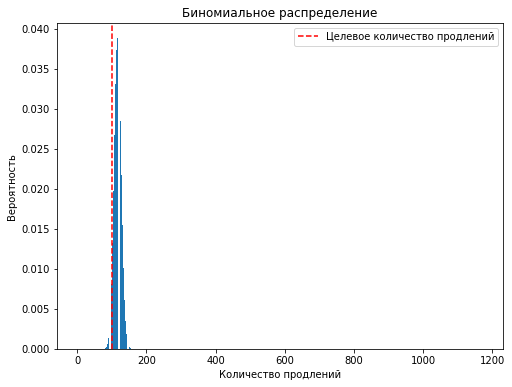

In [37]:
p = 0.1  
k = 100  
alpha = 0.05  

# Функция для расчета минимального количества промокодов
def min_promos(p, k, alpha):
    n = 1000
    step = 1
    while True:
        prob = binom.cdf(k, n, p)
        if prob <= alpha:
            return n
        n += step

# Расчет минимального количества промокодов
n = min_promos(p, k, alpha)
print(f"Минимальное количество промокодов: {n}")

# Построение графика распределения
x = np.arange(0, n+1)
pmf = binom.pmf(x, n, p)

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x, pmf)
ax.axvline(k, color='r', linestyle='--', label='Целевое количество продлений')
ax.set_xlabel('Количество продлений')
ax.set_ylabel('Вероятность')
ax.set_title('Биномиальное распределение')
ax.legend()
plt.show()

**Общий вывод**

В данном пункте было посчитано приблизительное количество для рассылки промокодов для того, чтобы выполнить план. 

Были использованы инструменты статистического анализа, а также написана функция для рассчета минимального числа промокодов. 

Построен график распределения этой величины.

#### Итоги:

На основании проведенного анализа данных и проверки гипотез можно сделать следующие ключевые выводы и рекомендации для дальнейшего улучшения сервиса GoFast:

**Популярность сервиса в городах**
Анализ частоты встречаемости пользователей по городам показал, что сервис наиболее популярен в регионах, таких как Пятигорск, Екатеринбург и Ростов-на-Дону. Наименьшее количество пользователей зарегистрировано в Москве. Это может свидетельствовать о том, что сервис имеет потенциал для роста в столице и других крупных городах.

**Типы подписок**
Большинство пользователей предпочитают бесплатную подписку (835 пользователей), в то время как платную подписку "Ultra" используют 699 пользователей. Это указывает на необходимость улучшения маркетинговых стратегий для привлечения пользователей к платным подпискам. Возможно, стоит рассмотреть дополнительные преимущества для подписчиков "Ultra" или временные акции для перехода на платную подписку.

**Возраст пользователей**
Средний возраст пользователей составляет примерно 24.9 года, а медианный возраст — 25 лет. Это говорит о том, что основная аудитория сервиса — молодые люди. Данные не содержат серьезных выбросов и аномалий, что свидетельствует о хорошем качестве данных.

**Поведение пользователей**
- **Продолжительность поездок:** Пользователи с подпиской "Ultra" тратят больше времени на поездки (в среднем 18.54 минуты) по сравнению с пользователями без подписки (17.39 минуты). Это статистически значимое различие.
- **Расстояние поездок:** Среднее расстояние поездки пользователей с подпиской составляет 3115.45 метров, что не превышает установленное оптимальное значение в 3130 метров.
- **Выручка:** Средняя помесячная выручка от пользователей с подпиской "Ultra" значительно выше, чем от пользователей без подписки. Это подтверждается статистически значимыми результатами.

**Обновление серверов**
Обновление серверов привело к значимому снижению количества обращений в техподдержку. Это подтверждает эффективность проведенных технических улучшений и их положительное влияние на пользовательский опыт.

**Промокоды**
Для выполнения плана по количеству продлений подписок, было рассчитано минимальное количество промокодов, которое составляет 1172. Это количество необходимо для достижения целевого показателя продлений.

**Рекомендации**
1. **Маркетинг и продвижение:** Усилить маркетинговые усилия в Москве и других крупных городах для увеличения базы пользователей. Рассмотреть возможность проведения акций и предложений для перехода на платную подписку "Ultra".
2. **Улучшение подписки "Ultra":** Ввести дополнительные преимущества для подписчиков "Ultra", чтобы сделать эту подписку более привлекательной.
3. **Технические улучшения:** Продолжить работу над техническими улучшениями сервиса, так как это приводит к снижению количества обращений в техподдержку и улучшению пользовательского опыта.
4. **Анализ и мониторинг:** Регулярно проводить анализ данных и мониторинг ключевых показателей для своевременного выявления проблем и возможностей для улучшения сервиса.

Эти выводы и рекомендации помогут в дальнейшем развитии сервиса GoFast, улучшении пользовательского опыта и увеличении выручки.